# 종합실습 1 - 인도 중고차 매매 가격 예측



### 데이터 설명

- Price(연속형): 중고차 가격(단위: 천 원) -> 목표변수
- Name(연속형): 자동차 브랜드와 모델
- Location(범주형): 자동차를 팔거나 구매할 수 있는 위치
- Year(연속형): 모델의 년도 혹은 버전
- Kilometers_Driven(연속형): 이전 소유주의 차량 주행거리(Km)
- Fuel_Type(범주형): 자동차 사용연료
- Transmission(범주형): 자동차 변속기 종류
- Owner_Type(범주형): 소유권이 직접 소유인지, 중고 소유인지 여부
- Mileage(연속형): 자동차 회사가 제공하는 표준 수행거리
- Engine(연속형): 엔진의 배기량(cc)
- Power(연속형): 엔진의 최대 출력(bhp)
- Seats(연속형): 차의 좌석 수
- New_Price(연속형): 뉴모델의 가격


# 데이터 불러오기

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import scipy
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest
import statsmodels.formula.api as smf
from statsmodels.api import qqplot, add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.tree import export_graphviz
import graphviz
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from xgboost import plot_importance

from statsmodels.formula.api import ols
import statsmodels.api as sm

sns.set_palette('Blues')
plt.rcParams['font.family'] = 'NanumGothic'
matplotlib.rc("font",family = "NanumGothic")
matplotlib.rc("axes",unicode_minus = False)

In [2]:
# 한글과 음수 표시
matplotlib.rc('font', family = 'NanumBarunGothic')
matplotlib.rc('axes', unicode_minus = False)

In [3]:
df = pd.read_csv('C:/Users/dnjse/Downloads/Car.csv', encoding = 'euc-kr')
df.head()

,Name,Location,Price,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price
0,Maruti Wagon R LXI CNG,Mumbai,2682.68,2010,72000,CNG,Manual,First,26.6 kmpl,998 CC,58.16 bhp,5.0,NaN
1,Hyundai Creta 1.6 CRDi SX Option,Pune,19162.00,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,NaN
2,Honda Jazz V,Chennai,6898.32,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,8.61 Lakh
3,Maruti Ertiga VDI,Chennai,9197.76,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,NaN
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,27194.71,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,NaN


In [4]:
print('행 수: ', df.shape[0],'\n')
print('열 수: ', df.shape[1],'\n')
print('자료형: ','\n', df.dtypes,'\n')
print('결측치 : ','\n', df.isnull().sum())

행 수:  7253 

열 수:  13 

자료형:  
 Name                  object
Location              object
Price                float64
Year                   int64
Kilometers_Driven      int64
Fuel_Type             object
Transmission          object
Owner_Type            object
Mileage               object
Engine                object
Power                 object
Seats                float64
New_Price             object
dtype: object 

결측치 :  
 Name                    0
Location                0
Price                1053
Year                    0
Kilometers_Driven       0
Fuel_Type               0
Transmission            0
Owner_Type              0
Mileage                 2
Engine                 46
Power                  46
Seats                  53
New_Price            6247
dtype: int64


- 종속변수 Price와 Mileage, Engine, Power, Seats, New_Price 변수에 결측치 존재

In [5]:
# 수치형 변수 기술통계량 확인

df.describe()

,Price,Year,Kilometers_Driven,Seats
count,6200.000000,7253.000000,7.253000e+03,7200.000000
mean,14912.514750,2013.365366,5.869906e+04,5.279722
std,17674.318464,3.254421,8.442772e+04,0.811660
min,7.080000,1996.000000,1.710000e+02,0.000000
25%,5365.360000,2011.000000,3.400000e+04,5.000000
50%,8814.520000,2014.000000,5.341600e+04,5.000000
75%,15869.972500,2016.000000,7.300000e+04,5.000000
max,245273.600000,2019.000000,6.500000e+06,10.000000


In [6]:
# 범주형 변수 기술통계량 확인

df.describe(include = ['object', 'string'])

,Name,Location,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,New_Price
count,7253,7253,7253,7253,7253,7251,7207,7207,1006
unique,2041,11,5,2,4,438,150,386,625
top,Mahindra XUV500 W8 2WD,Mumbai,Diesel,Manual,First,17.0 kmpl,1197 CC,74 bhp,63.71 Lakh
freq,55,949,3852,5204,5952,208,732,280,6


- Name은 첫 단어가 회사명이므로, 추후 추출하여 변수로 활용 예정

In [7]:
# 각 범주형 변수별 범주의 빈도 확인

print(df['Location'].value_counts())
print()
print(df['Fuel_Type'].value_counts())
print()
print(df['Transmission'].value_counts())
print()
print(df['Owner_Type'].value_counts())
print()
print(df['New_Price'].value_counts())

Mumbai        949
Hyderabad     876
Coimbatore    772
Kochi         772
Pune          765
Delhi         660
Kolkata       654
Chennai       591
Jaipur        499
Bangalore     440
Ahmedabad     275
Name: Location, dtype: int64

Diesel      3852
Petrol      3325
CNG           62
LPG           12
Electric       2
Name: Fuel_Type, dtype: int64

Manual       5204
Automatic    2049
Name: Transmission, dtype: int64

First             5952
Second            1152
Third              137
Fourth & Above      12
Name: Owner_Type, dtype: int64

63.71 Lakh    6
95.13 Lakh    6
4.78 Lakh     6
33.36 Lakh    6
44.28 Lakh    5
             ..
6.83 Lakh     1
9.09 Lakh     1
7.17 Lakh     1
11.77 Lakh    1
18.16 Lakh    1
Name: New_Price, Length: 625, dtype: int64


- Maruti, Hyundai, Honda 순으로 빈도가 높음(매매횟수가 많음)


- 인도의 중고차 시장에서 상위 3 회사의 차량이 많이 유통됨을 알 수 있음

### 결측치 처리

In [8]:
# 단위를 나타내는 항목 제외

df['Engine'] = df['Engine'].str.rstrip(' CC')
df['Mileage'] = df['Mileage'].str.rstrip( 'kmpl')
df['Power'] = df['Power'].str.rstrip(' bhp')
df['Power'] = df['Power'].replace(regex = 'null', value = np.nan) # nan과 null이 섞여 있어 null값을 nan으로 변환
df['New_Price'] = df['New_Price'].str.rstrip(' Lakh')

In [9]:
# 단위 제거한 변수의 타입 숫자형으로 변환

df['Mileage'] = df['Mileage'].astype('float64')
df['Engine'] = df['Engine'].astype('float64')
df['Power'] = df['Power'].astype('float64')

In [10]:
df.isnull().sum()

Name                    0
Location                0
Price                1053
Year                    0
Kilometers_Driven       0
Fuel_Type               0
Transmission            0
Owner_Type              0
Mileage                 2
Engine                 46
Power                 175
Seats                  53
New_Price            6247
dtype: int64

- Power 변수의 결측치가 증가한 것을 확인

In [11]:
df.loc[df['Fuel_Type'] == 'Electric']

,Name,Location,Price,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price
4446,Mahindra E Verito D4,Chennai,19928.48,2016,50000,Electric,Automatic,First,NaN,72.0,41.0,5.0,13.58
4904,Toyota Prius 2009-2016 Z4,Mumbai,19545.24,2011,44000,Electric,Automatic,First,NaN,1798.0,73.0,5.0,NaN


In [12]:
df = df.loc[df['Fuel_Type'] != 'Electric']

- 전기차는 배기량이 없기 때문에 배기량이 존재하는 관측치 또한 제거할 것

#### - 결측치 제거

In [13]:
# 목표변수의 결측치는 삭제

df = df.dropna(subset = ['Price'])

- 목표변수의 결측치를 임의로 대체한다면, 데이터 조작 가능성과 모델 변형을 야기할 수 있음


- 따라서, 정보를 잃더라도 목표변수의 결측치를 제거하여 신뢰성 있는 모델을 구축하고자 함

In [14]:
# 결측치 비율이 80% 이상인 New_Price 제거

df = df.drop('New_Price', axis = 1)
df.head()

,Name,Location,Price,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats
0,Maruti Wagon R LXI CNG,Mumbai,2682.68,2010,72000,CNG,Manual,First,26.60,998.0,58.16,5.0
1,Hyundai Creta 1.6 CRDi SX Option,Pune,19162.00,2015,41000,Diesel,Manual,First,19.67,1582.0,126.20,5.0
2,Honda Jazz V,Chennai,6898.32,2011,46000,Petrol,Manual,First,18.20,1199.0,88.70,5.0
3,Maruti Ertiga VDI,Chennai,9197.76,2012,87000,Diesel,Manual,First,20.77,1248.0,88.76,7.0
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,27194.71,2013,40670,Diesel,Automatic,Second,15.20,1968.0,140.80,5.0


- New_Price의 경우, 결측치 비율이 80%를 초과하여 모델 구축 시 성능이 낮아질 수 있는 문제가 발생할 수 있기 때문에 변수 자체를 |제거하였음

In [15]:
# 설명변수의 결측치 제거

df = df.dropna(subset = ['Mileage','Engine','Power','Seats'])
df.isnull().sum()

Name                 0
Location             0
Price                0
Year                 0
Kilometers_Driven    0
Fuel_Type            0
Transmission         0
Owner_Type           0
Mileage              0
Engine               0
Power                0
Seats                0
dtype: int64

- Engine과 Power의 경우, 같은 모델에서 같은 값을 갖지만, 타 모델에서도 같은 값을 가지는 경우가 있음


- 따라서, 임의적으로 대체할 수 없다고 판단하여 제거하였음


- Mileage와 Seat 변수는 결측치 수가 미비하여 모델에 사용될 데이터의 정보가 훼손될 가능성이 적다고 판단하여 제거하였음

#### - 파생변수 추가

In [16]:
# Name 변수에서 회사 브랜드 추출 후 파생변수로 추가

df[['Name', 'Name_UNIT']] = df['Name'].str.split(expand = True, n = 1)
df = df.drop(['Name_UNIT'], axis = 1)
df['Name'].head()

0     Maruti
1    Hyundai
2      Honda
3     Maruti
4       Audi
Name: Name, dtype: object

In [17]:
print(df['Name'].value_counts())

Maruti           1218
Hyundai          1079
Honda             614
Toyota            406
Mercedes-Benz     323
Volkswagen        320
Ford              298
Mahindra          278
BMW               268
Audi              240
Tata              192
Skoda             181
Renault           151
Chevrolet         120
Nissan             93
Land               57
Jaguar             43
Mitsubishi         34
Mini               29
Fiat               26
Volvo              21
Jeep               19
Datsun             17
Porsche            16
ISUZU               3
Force               3
Bentley             2
Ambassador          1
Lamborghini         1
Name: Name, dtype: int64


In [18]:
# 생산연도 파생변수 추가
df['Year_start'] = 2023 - df['Year']
df['Year_start'].head()

0    13
1     8
2    12
3    11
4    10
Name: Year_start, dtype: int64

# EDA(Exploratory Data Analysis)

array([[<AxesSubplot:title={'center':'Price'}>,
        <AxesSubplot:title={'center':'Year'}>,
        <AxesSubplot:title={'center':'Kilometers_Driven'}>],
       [<AxesSubplot:title={'center':'Mileage'}>,
        <AxesSubplot:title={'center':'Engine'}>,
        <AxesSubplot:title={'center':'Power'}>],
       [<AxesSubplot:title={'center':'Seats'}>,
        <AxesSubplot:title={'center':'Year_start'}>, <AxesSubplot:>]],
      dtype=object)

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


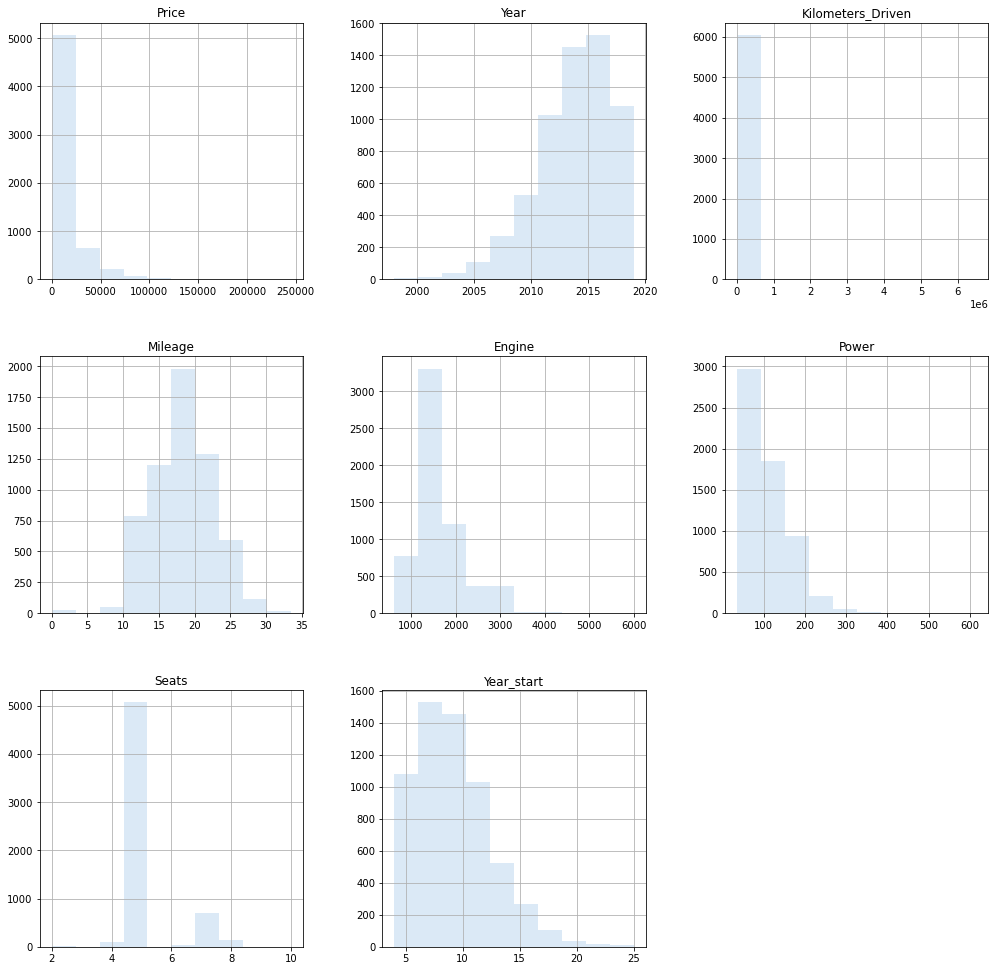

In [19]:
df.hist(figsize=(17,17))

- Seats 변수는 5인용이 제일 많음


- 모든 변수가 정규성을 띄지 않음

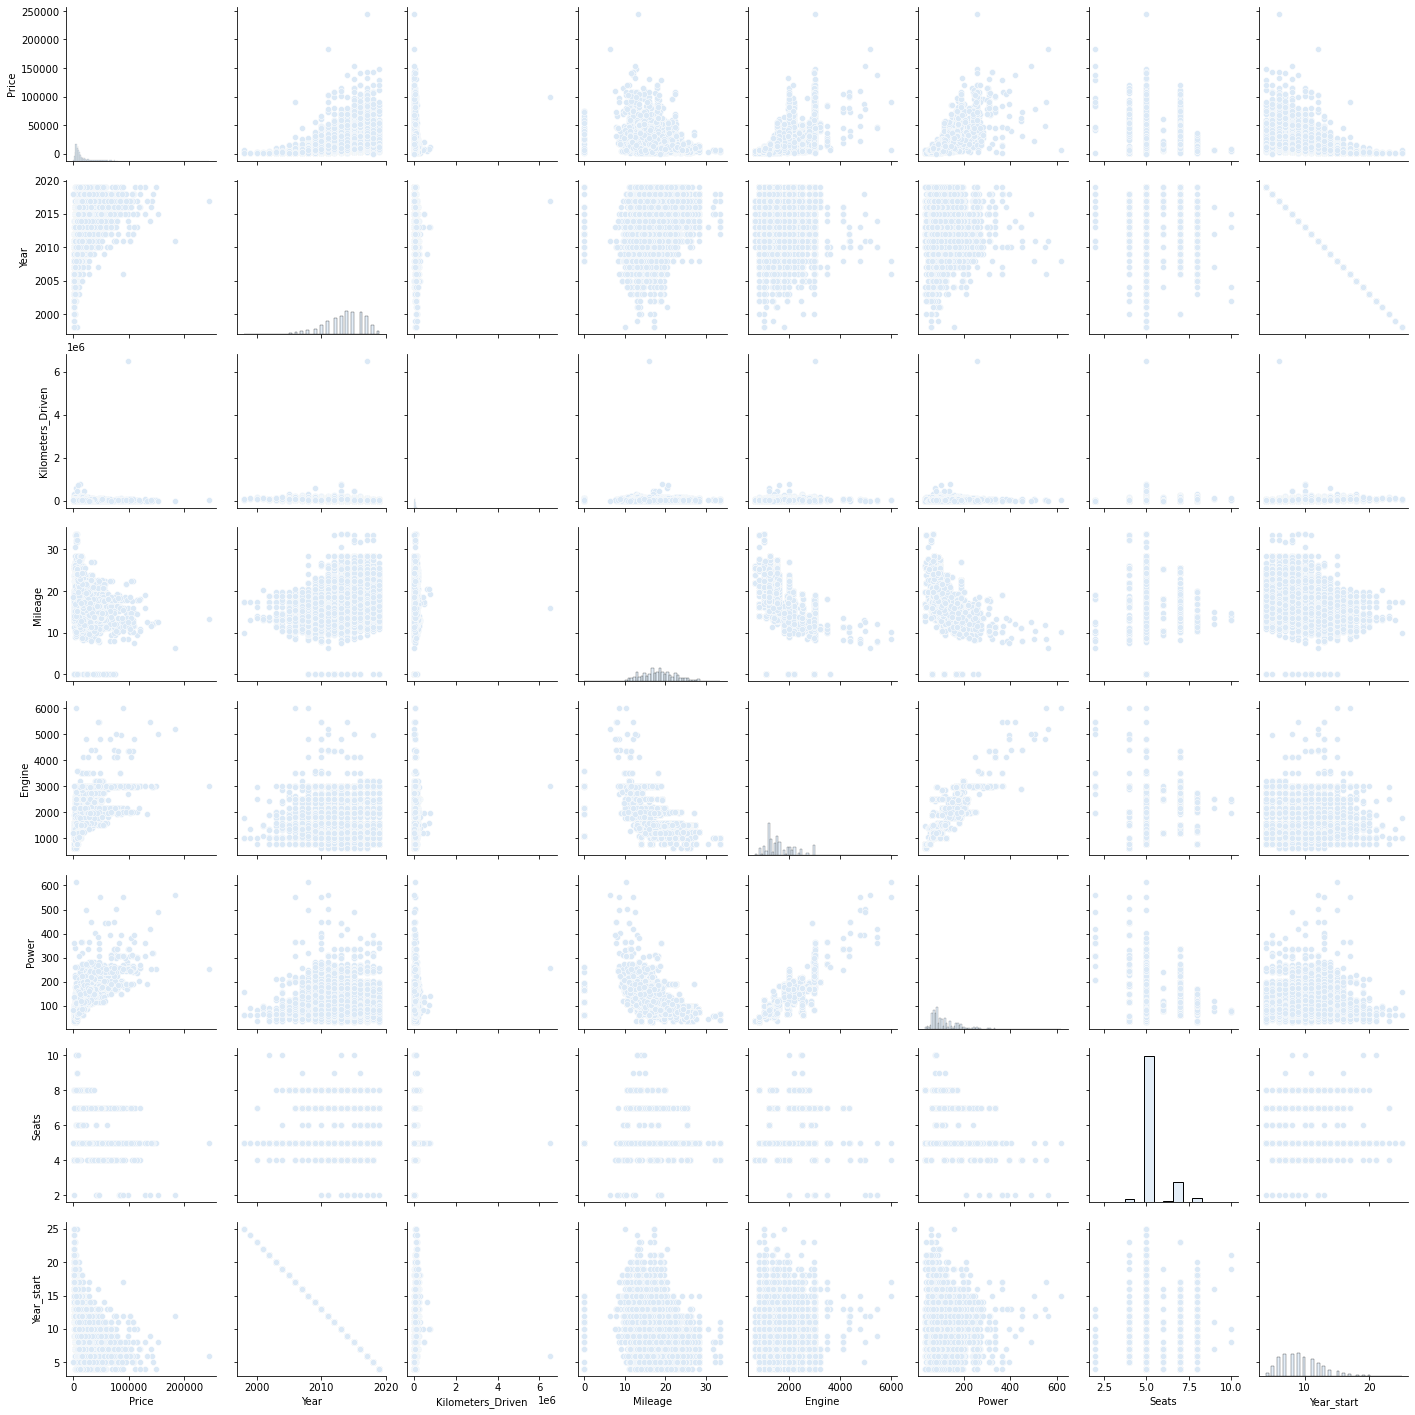

In [20]:
# pairplot
sns.pairplot(df)

- 종속변수 중고차 가격은 엔진 최대출력량과, 생산연도과의 상관관계가 있는 것으로 나타남


- 엔진배기량과 엔진 최대출력량은 높은 상관관계를 가지며, 다중공선성 문제가 의심됨


- 주행거리와 연식 변수 간의 양의 상관관계가 존재하는 것으로 보임

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


<AxesSubplot:title={'center':'상관계수행렬 히트맵'}>

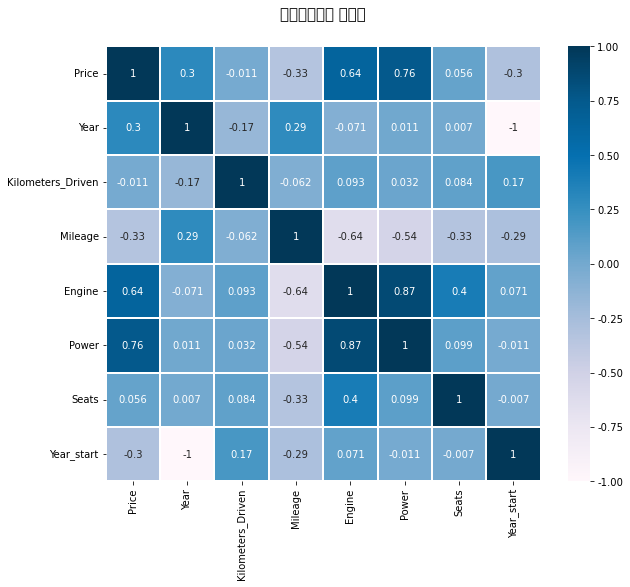

In [21]:
cor_df = df.corr().round(3)

colormap = plt.cm.PuBu
plt.figure(figsize=(10, 8))
plt.title("상관계수행렬 히트맵", y = 1.05, size = 15)
sns.heatmap(cor_df, linewidths = 0.1, vmax = 1.0,
           square = True, cmap = colormap, linecolor = "white", annot = True)

- 엔진 최대출력과 배기량은 중고차 가격과 강한 상관관계(각각 0.72, 0.64)가 있는 것으로 나타남
  - 최대출력, 배기량은 중고차 가격 형성에 큰 요인일 것
  
  
- 배기량과 최대출력 간 상관계수가 0.85로 아주 강한 상관관계가 나타남


- 연식과 주행거리 간의 상관계수가 0.52로 나타남


- 엔진 최대출력과 배기량, 표준주행거리(회사 제공) 간의 상관계수는 각각 -0.55, -0.64로 음의 상관관계를 가짐


- 표준 주행거리와 중고차 가격 간의 상관게수는 -0.43으로 나타남
    - 표준 주행거리가 높다고 해서 중고차 가격이 높은 것은 아님
    - 회사에서 제공하는 표준 주행거리가 중고차 가격 형성에 큰 영향을 미치지 않는 것으로 판단됨

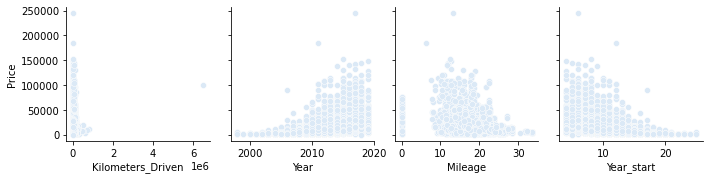

In [22]:
sns.pairplot(df, y_vars=['Price'], x_vars=['Kilometers_Driven', 'Year', 'Mileage', 'Year_start'])

- 신차일수록 매매 가격이 높고, 표준 주행거리는 가격과는 큰 상관이 없음

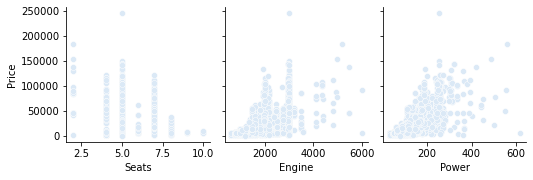

In [23]:
sns.pairplot(df, y_vars=['Price'], x_vars=['Seats', 'Engine', 'Power'])

- 엔진 배기량과 최대 출력이 높을 수록 매매 가격이 비싸지는 경향을 보임

In [24]:
# 그룹화를 통한 목표변수와 설명변수 간 관계 확인(내림차순)

df.groupby(['Power','Engine'])['Price'].mean().sort_values(ascending = False)

Power  Engine
560.0  5204.0    183955.200000
488.1  5000.0    153296.000000
320.0  2979.0    143078.820000
421.0  5461.0    137966.400000
255.0  2993.0    120293.926667
                     ...      
52.8   1396.0      1349.005000
68.0   1405.0      1318.350000
37.0   796.0       1173.990833
62.0   1405.0      1073.070000
68.0   1086.0      1073.070000
Name: Price, Length: 577, dtype: float64

- Power가 높고 Engine이 클수록 평균 매매 가격이 높음

In [25]:
# 브랜드별 각 판매 지역의 중고차 평균 가격

a = pd.DataFrame(df.groupby(['Name','Location'])['Price'].mean().reset_index())
a = a.pivot(index = 'Name',columns = 'Location', values = 'Price')
a = a.fillna(0)
print(a.shape)
a.head()

(29, 11)


Location,Ahmedabad,Bangalore,Chennai,Coimbatore,Delhi,Hyderabad,Jaipur,Kochi,Kolkata,Mumbai,Pune
Name,,,,,,,,,,,
Ambassador,0.000000,0.000000,2069.500000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000
Audi,26429.623636,43610.316562,40921.515556,50835.607115,29178.474074,45689.625806,25102.220,41039.178400,22960.866250,36928.392800,37174.280000
BMW,37650.519333,45726.803182,41709.104643,49932.887143,32092.516875,37210.977879,41619.864,50261.042308,28320.846923,37495.281600,29091.901600
Bentley,0.000000,5748.600000,0.000000,0.000000,0.000000,90444.640000,0.000,0.000000,0.000000,0.000000,0.000000
Chevrolet,5403.685000,6098.991429,3695.612308,7034.892727,3122.126667,6216.153000,3671.439,5706.443750,3608.417222,4630.816667,3523.253889


In [26]:
a.mean().sort_values(ascending = False)

Location
Coimbatore    24996.353264
Delhi         24886.646176
Hyderabad     23406.424970
Kochi         20778.422202
Bangalore     20715.307115
Mumbai        17795.544540
Kolkata       15843.777819
Pune          14289.429376
Chennai       12667.698582
Ahmedabad     12495.151736
Jaipur        11883.479351
dtype: float64

- Hyderabad, Coimbastore, Kochi 순으로 중고차 평균가격이 높음을 알 수 있음

In [27]:
# 브랜드별 각 판매 지역의 중고차 판매횟수

a = pd.DataFrame(df.groupby(['Name','Location'])['Price'].count().reset_index())
a = a.pivot(index = 'Name',columns = 'Location', values = 'Price')
a = a.fillna(0)
print(a.shape)
a.head()

(29, 11)


Location,Ahmedabad,Bangalore,Chennai,Coimbatore,Delhi,Hyderabad,Jaipur,Kochi,Kolkata,Mumbai,Pune
Name,,,,,,,,,,,
Ambassador,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Audi,11.0,32.0,9.0,52.0,27.0,31.0,4.0,25.0,16.0,25.0,8.0
BMW,15.0,22.0,28.0,35.0,16.0,33.0,5.0,26.0,13.0,50.0,25.0
Bentley,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
Chevrolet,2.0,7.0,13.0,11.0,3.0,10.0,10.0,16.0,18.0,12.0,18.0


In [28]:
a.sum().sort_values(ascending = False)

Location
Mumbai        802.0
Hyderabad     735.0
Kochi         670.0
Coimbatore    657.0
Pune          604.0
Delhi         563.0
Kolkata       538.0
Chennai       488.0
Jaipur        413.0
Bangalore     354.0
Ahmedabad     229.0
dtype: float64

- 총 판매횟수는 Mumbai, Hyderabad, Kochi 순으로 높음


- Hyderabad의 경우 비싼 중고차가 자주 매매되는 곳으로 판단됨


- Mumbai의 경우 중고차 평균 가격은 높지 않지만, 매매 횟수가 높은 것으로 보아 주 소비층이 중산층인 것으로 예상됨

In [29]:
# 연료별 중고차 평균 가격, 총 가격, 판매횟수

df.groupby(['Fuel_Type'])['Price'].agg(['mean', 'sum','count']).sort_values(by = 'mean',ascending = False)

,mean,sum,count
Fuel_Type,,,
Diesel,20324.953916,66015450.32,3248
Petrol,9156.956302,25080903.31,2739
CNG,5485.806607,307205.17,56
LPG,3812.472000,38124.72,10


- Diesel, Petrol 연료를 쓰는 중고차의 매매 횟수가 높음


- 하지만 Petrol과 달리 Diesel 연료를 사용하는 중고차의 가격이 2배 넘게 비쌈

In [30]:
# 브랜드별 별 중고차 평균 가격, 총 가격, 판매횟수}

df.groupby(['Name'])['Price'].agg(['mean','sum','count']).sort_values(by = 'mean', ascending = False)

,mean,sum,count
Name,,,
Lamborghini,183955.200000,183955.20,1
Porsche,75428.338750,1206853.42,16
Land,61105.399123,3483007.75,57
Jaguar,59961.551628,2578346.72,43
Bentley,48096.620000,96193.24,2
Mini,43103.134828,1249990.91,29
Mercedes-Benz,42304.095666,13664222.90,323
Audi,40069.019417,9616564.66,240
BMW,39973.190410,10712815.03,268


- 랜드로버, 벤츠, 재규어 순으로 평균 매매 가격이 높음

In [31]:
df.groupby(['Name'])['Price'].agg(['mean','sum','count']).sort_values(by = 'count', ascending = False)

,mean,sum,count
Name,,,
Maruti,7122.121921,8674744.50,1218
Hyundai,8659.696080,9343812.07,1079
Honda,8545.178078,5246739.34,614
Toyota,18709.550222,7596077.39,406
Mercedes-Benz,42304.095666,13664222.90,323
Volkswagen,8341.792969,2669373.75,320
Ford,10731.543054,3197999.83,298
Mahindra,12459.987230,3463876.45,278
BMW,39973.190410,10712815.03,268


- Maruti,현대, 도요타 순으로 판매 횟수가 많음


- Maruti는 인도 현지 업체로써, 가족 단위 SUV 차량을 주로 판매하여 판매횟수가 많은 것으로 판단됨

In [32]:
# 주행거리 별 중고차 평균 가격, 총 가격, 판매횟수}

df.groupby(['Kilometers_Driven'])['Price'].agg(['mean','sum','count']).sort_values(by = 'mean', ascending = False)

,mean,sum,count
Kilometers_Driven,,,
6500,183955.20,183955.20,1
26013,148804.43,148804.43,1
28060,143592.36,143592.36,1
17465,142565.28,142565.28,1
97003,130301.60,130301.60,1
...,...,...,...
5834,1226.37,1226.37,1
133000,1195.71,2391.42,2
65771,1149.72,1149.72,1


- 주행거리와 매매가격 간에는 큰 상관관계를 찾지 못함

In [33]:
# 소유주별 중고차 평균 가격, 총 가격, 판매횟수

df.groupby(['Owner_Type'])['Price'].agg(['mean','sum','count']).sort_values(by = 'mean', ascending = False)

,mean,sum,count
Owner_Type,,,
First,15836.017139,79259265.78,5005
Second,12046.407309,11323622.87,940
Third,8123.929307,820516.86,101
Fourth & Above,5468.287143,38278.01,7


- 차주가 바뀐 횟수만큼 매매 가격이 하락


- 또한 중고차 매매고객들은 판매 횟수가 적은 중고차를 선호

In [34]:
# 변속기별 중고차 평균 가격, 총 가격, 판매횟수

df.groupby(['Transmission'])['Price'].agg(['mean','sum','count']).sort_values(by = 'mean', ascending = False)

,mean,sum,count
Transmission,,,
Automatic,31193.939049,55088496.36,1766
Manual,8479.866377,36353187.16,4287


- 자동 변속기 차량이 수동 변속기 차량에 비해 매매 가격이 높음


- 하지만 대부분의 고객들은 가격이 싼 수동 변속기 차량을 구매하는 경향을 보임

In [35]:
# 시트수별 중고차 평균 가격, 총 가격, 판매횟수

df.groupby(['Seats'])['Price'].agg(['mean','sum','count']).sort_values(ascending = False, by = 'count')

,mean,sum,count
Seats,,,
5.0,13563.092428,68751315.52,5069
7.0,23130.318103,16098701.40,696
8.0,11835.586444,1597804.17,135
4.0,32021.730392,3266216.50,102
6.0,15191.633667,455749.01,30
2.0,87427.994286,1223991.92,14
10.0,6859.995000,27439.98,4
9.0,6821.673333,20465.02,3


- 5인용 중고차의 판매빈도가 가장 높음


- 가족 단위 소비자가 많을 것으로 예상됨

- 시트 수와 브랜드별 판매 횟수 간의 관계를 보았을 때, 다인용 SUV 차량을 인도에서 선호하는 것으로 유추할 수 있음


- 따라서, 이러한 가설을 세움으로써 향후 분석에 활용될 것으로 기대됨

# 데이터 정제

#### 이상치 확인

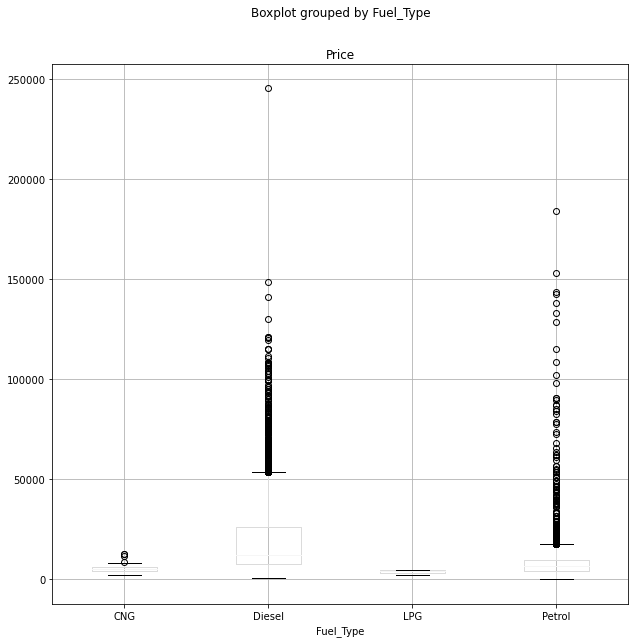

In [36]:
# 박스플롯 확인

df.boxplot(column=["Price"], by = 'Fuel_Type', figsize = (10,10))
plt.show()

<AxesSubplot:>

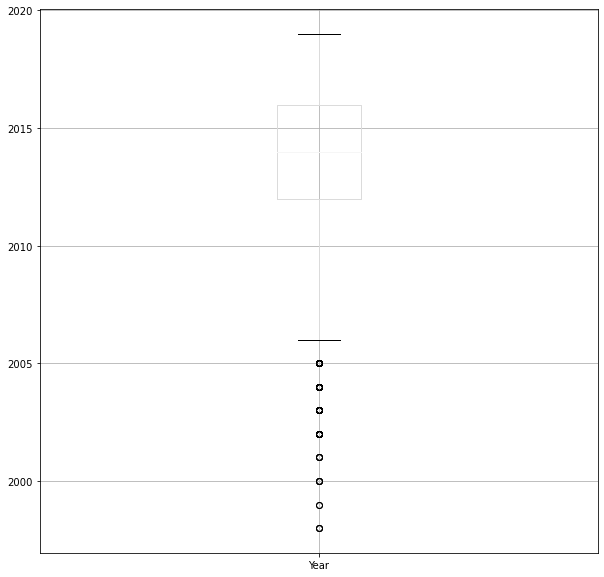

In [37]:
# Year Boxplot

df.boxplot('Year', figsize = (10,10))

- 생산연도가 오래된 관측값들이 이상치로 나타남


- 생산연도가 오래될수록 가격이 낮아지는 경향을 보였기 때문에 이상치로 판별하지 않음


- 따라서 이상치 대체 및 제거 등의 작업과정을 생략

<AxesSubplot:>

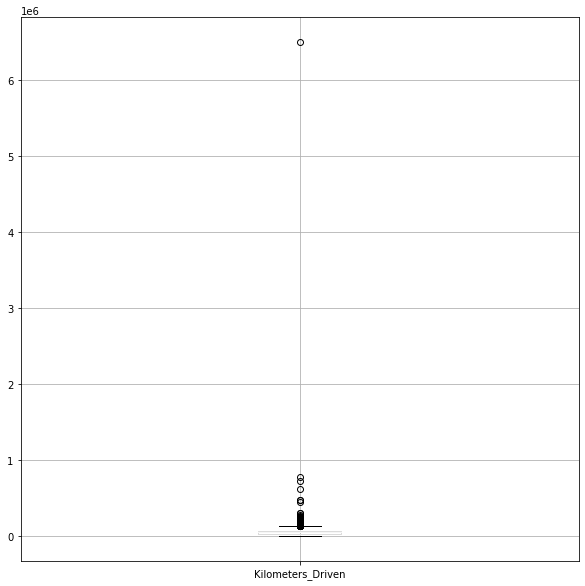

In [38]:
# Kilometers_Driven Boxplot

df.boxplot('Kilometers_Driven', figsize = (10,10))

- 주행거리가 많은 관측치가 이상치로 나타남

In [39]:
df = df.loc[df['Kilometers_Driven']< 200000]
df

,Name,Location,Price,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Year_start
0,Maruti,Mumbai,2682.68,2010,72000,CNG,Manual,First,26.60,998.0,58.16,5.0,13
1,Hyundai,Pune,19162.00,2015,41000,Diesel,Manual,First,19.67,1582.0,126.20,5.0,8
2,Honda,Chennai,6898.32,2011,46000,Petrol,Manual,First,18.20,1199.0,88.70,5.0,12
3,Maruti,Chennai,9197.76,2012,87000,Diesel,Manual,First,20.77,1248.0,88.76,7.0,11
4,Audi,Coimbatore,27194.71,2013,40670,Diesel,Automatic,Second,15.20,1968.0,140.80,5.0,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7228,Tata,Pune,10822.70,2016,41413,Diesel,Manual,First,27.28,1047.0,69.00,5.0,7
7231,Ford,Kochi,13474.72,2017,39015,Petrol,Manual,First,17.00,1497.0,121.36,5.0,6
7232,Jeep,Mumbai,27838.55,2018,6000,Petrol,Manual,First,16.00,1368.0,160.00,5.0,5
7235,Maruti,Kochi,16203.39,2017,21380,Diesel,Manual,First,24.30,1248.0,88.50,5.0,6


- 폐차시 중고차 평균 주행거리는 연평균 200,000km로, 이상치로 판단된 관측치는 폐차로 판단하여 제거하였음 

<AxesSubplot:>

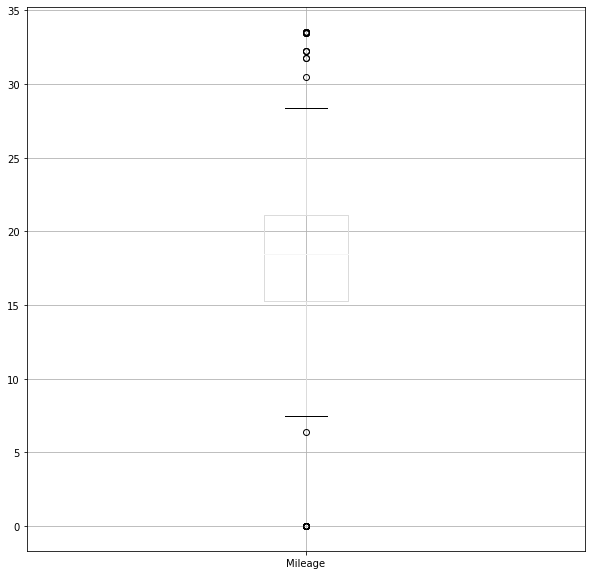

In [40]:
# Mileage Boxplot

df.boxplot('Mileage',  figsize = (10,10))

In [41]:
df = df.loc[df['Mileage']> 0]
df

,Name,Location,Price,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Year_start
0,Maruti,Mumbai,2682.68,2010,72000,CNG,Manual,First,26.60,998.0,58.16,5.0,13
1,Hyundai,Pune,19162.00,2015,41000,Diesel,Manual,First,19.67,1582.0,126.20,5.0,8
2,Honda,Chennai,6898.32,2011,46000,Petrol,Manual,First,18.20,1199.0,88.70,5.0,12
3,Maruti,Chennai,9197.76,2012,87000,Diesel,Manual,First,20.77,1248.0,88.76,7.0,11
4,Audi,Coimbatore,27194.71,2013,40670,Diesel,Automatic,Second,15.20,1968.0,140.80,5.0,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7228,Tata,Pune,10822.70,2016,41413,Diesel,Manual,First,27.28,1047.0,69.00,5.0,7
7231,Ford,Kochi,13474.72,2017,39015,Petrol,Manual,First,17.00,1497.0,121.36,5.0,6
7232,Jeep,Mumbai,27838.55,2018,6000,Petrol,Manual,First,16.00,1368.0,160.00,5.0,5
7235,Maruti,Kochi,16203.39,2017,21380,Diesel,Manual,First,24.30,1248.0,88.50,5.0,6


<AxesSubplot:>

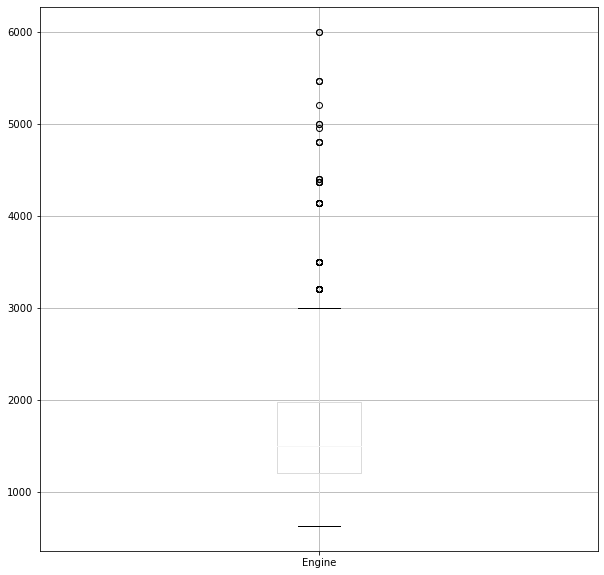

In [42]:
# Engine boxplot

df.boxplot('Engine',  figsize = (10,10))

In [43]:
# 이상치 검출
idx = df['Engine'].mean() + 3*df['Engine'].std()
idx2 = df['Engine'].quantile(.75) + 1.5 * (df['Engine'].quantile(.75) - df['Engine'].quantile(.25))
df.loc[df['Engine']>= idx2].sort_values(ascending = False, by = 'Engine')

,Name,Location,Price,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Year_start
6354,Bentley,Bangalore,5748.60,2008,31200,Petrol,Automatic,Second,10.20,5998.0,616.00,5.0,15
5521,Bentley,Hyderabad,90444.64,2006,48000,Petrol,Automatic,First,8.60,5998.0,552.00,4.0,17
4722,Mercedes-Benz,Kolkata,45222.32,2010,35000,Petrol,Automatic,First,8.10,5461.0,387.30,2.0,13
4691,Mercedes-Benz,Bangalore,137966.40,2014,3000,Petrol,Automatic,Second,12.00,5461.0,421.00,2.0,9
152,Mercedes-Benz,Kolkata,45988.80,2010,35277,Petrol,Automatic,First,7.81,5461.0,362.90,5.0,13
5781,Lamborghini,Delhi,183955.20,2011,6500,Petrol,Automatic,Third,6.40,5204.0,560.00,2.0,12
5919,Jaguar,Hyderabad,153296.00,2015,8000,Petrol,Automatic,First,12.50,5000.0,488.10,2.0,8
5088,Jaguar,Coimbatore,77659.75,2011,43686,Petrol,Automatic,First,10.50,5000.0,503.00,4.0,12
4451,Ford,Kochi,87072.13,2018,21290,Petrol,Automatic,First,13.00,4951.0,395.00,4.0,5
2100,Porsche,Mumbai,49054.72,2010,35000,Petrol,Automatic,Second,11.90,4806.0,550.00,5.0,13


- 이상치 조회 결과 프리미엄 차종인 경우가 많아 이상치를 따로 제거 및 대체하지 않음

<AxesSubplot:>

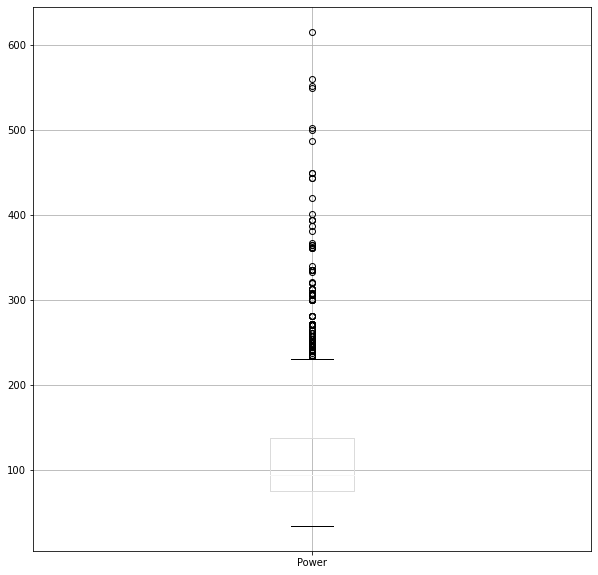

In [44]:
# Power boxplot

df.boxplot('Power',  figsize = (10,10))

In [45]:
idx2 = df['Power'].quantile(.75) + 1.5 * (df['Power'].quantile(.75) - df['Power'].quantile(.25))
df.loc[df['Power']>= idx2].sort_values(ascending = False, by = 'Power')

,Name,Location,Price,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Year_start
6354,Bentley,Bangalore,5748.60,2008,31200,Petrol,Automatic,Second,10.2,5998.0,616.0,5.0,15
5781,Lamborghini,Delhi,183955.20,2011,6500,Petrol,Automatic,Third,6.4,5204.0,560.0,2.0,12
5521,Bentley,Hyderabad,90444.64,2006,48000,Petrol,Automatic,First,8.6,5998.0,552.0,4.0,17
2100,Porsche,Mumbai,49054.72,2010,35000,Petrol,Automatic,Second,11.9,4806.0,550.0,5.0,13
5088,Jaguar,Coimbatore,77659.75,2011,43686,Petrol,Automatic,First,10.5,5000.0,503.0,4.0,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...
369,BMW,Bangalore,27210.04,2009,90000,Diesel,Automatic,Second,11.0,2993.0,235.0,5.0,14
1029,BMW,Pune,12248.35,2008,112500,Diesel,Automatic,First,11.5,2993.0,235.0,5.0,15
4798,BMW,Chennai,27593.28,2009,110000,Diesel,Automatic,First,11.0,2993.0,235.0,5.0,14
2654,BMW,Coimbatore,28298.44,2010,101119,Diesel,Automatic,First,11.0,2993.0,235.0,5.0,13


- 이상치 제거 X

<AxesSubplot:>

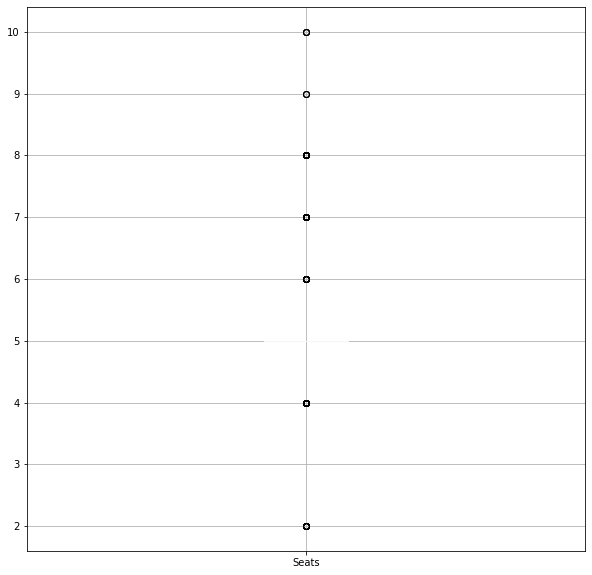

In [46]:
# Seats boxplot

df.boxplot('Seats',  figsize = (10,10))

- 이상치 제거 x

## ANOVA 분석

- 집단 간 평균차이를 검정하는 분석
- 범주형 변수를 ANOVA에 이용하기로 함

##### 중고차 가격과 지역에 대한 가설검정: AVONA

* H0 = 지역별 가격 평균의 차이가 없다.
* H1 = 지역별 가격 평균의 차이가 있다.

In [47]:
df['Location'].value_counts()

Mumbai        799
Hyderabad     725
Kochi         668
Coimbatore    654
Pune          597
Delhi         560
Kolkata       534
Chennai       473
Jaipur        407
Bangalore     349
Ahmedabad     227
Name: Location, dtype: int64

<AxesSubplot:xlabel='Location', ylabel='count'>

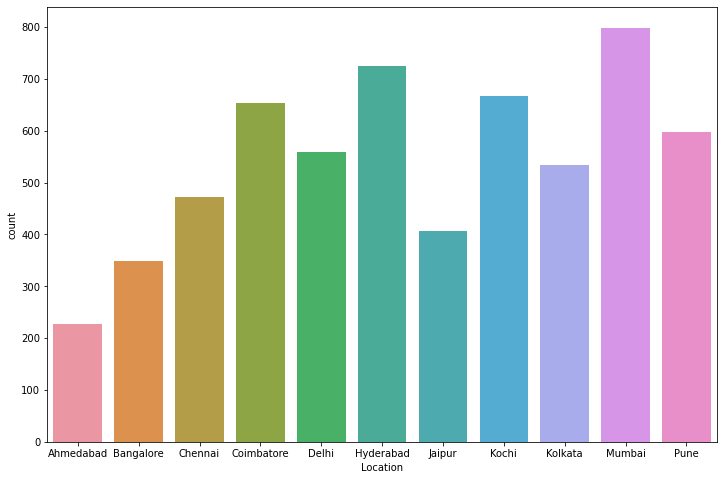

In [48]:
plt.figure(figsize  = (12,8))
df['Location'] = df['Location'].astype('category')
sns.countplot("Location", data=df)

In [49]:
model = ols('Price ~ Location', data=df).fit()
anova_table = sm.stats.anova_lm(model)
anova_table

,df,sum_sq,mean_sq,F,PR(>F)
Location,10.0,1.102417e+11,1.102417e+10,37.368441,7.949077e-72
Residual,5982.0,1.764767e+12,2.950129e+08,NaN,NaN


- F-통계량 : 37.368441
- p-value : 7.949077e-72


- 95% 신뢰구간에서 p-value가 0.05 미만으로, 귀무가설을 기각한다. 따라서 지역별 가격 평균에는 차이가 있다.

##### 중고차 가격과 연료 타입에 대한 가설검정: AVONA

* H0 = 연료타입별 가격 평균의 차이가 없다.
* H1 = 연료별 가격 평균의 차이가 있다.

In [50]:
df['Fuel_Type'].value_counts()

Diesel    3205
Petrol    2722
CNG         56
LPG         10
Name: Fuel_Type, dtype: int64

<AxesSubplot:xlabel='Fuel_Type', ylabel='count'>

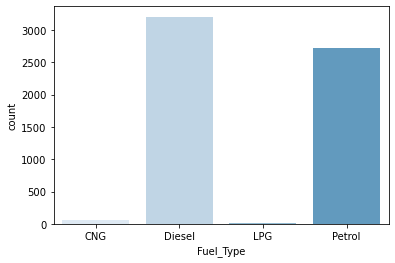

In [51]:
df['Fuel_Type'] = df['Fuel_Type'].astype('category')
sns.countplot("Fuel_Type", data=df)

In [52]:
model = ols('Price ~ Fuel_Type', data=df).fit()
anova_table = sm.stats.anova_lm(model)
anova_table

,df,sum_sq,mean_sq,F,PR(>F)
Fuel_Type,3.0,1.868938e+11,6.229792e+10,221.017024,5.465654e-136
Residual,5989.0,1.688115e+12,2.818693e+08,NaN,NaN


- F-통계량 : 221.017024
- p-value : 5.465654e-136


- 95% 신뢰구간에서 p-value가 0.05 미만으로, 귀무가설을 기각한다. 따라서 연료타입별 가격 평균에는 차이가 있다.

##### 중고차 가격과 변속기 종류에 대한 가설검정: AVONA

* H0 = 연료타입별 가격 평균의 차이가 없다.
* H1 = 연료별 가격 평균의 차이가 있다.

In [53]:
df['Transmission'].value_counts()

Manual       4253
Automatic    1740
Name: Transmission, dtype: int64

<AxesSubplot:xlabel='Transmission', ylabel='count'>

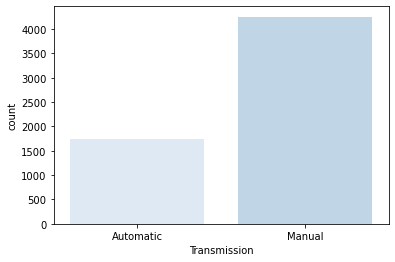

In [54]:
df['Transmission'] = df['Transmission'].astype('category')
sns.countplot("Transmission", data=df)

In [55]:
model = ols('Price ~ Transmission', data=df).fit()
anova_table = sm.stats.anova_lm(model)
anova_table

,df,sum_sq,mean_sq,F,PR(>F)
Transmission,1.0,6.278369e+11,6.278369e+11,3015.919206,0.0
Residual,5991.0,1.247172e+12,2.081743e+08,NaN,NaN


- F-통계량 : 3015.919206
- p-value : 0

- 95% 신뢰구간에서 p-value가 0.05 미만으로, 귀무가설을 기각한다. 따라서 변속기별 가격 평균에는 차이가 있다.

##### 중고차 가격과 소유권 변경 횟수에 대한 가설검정: AVONA

* H0 = 소유권 변경횟수별 가격 평균의 차이가 없다.
* H1 = 소유권 변경횟수별 가격 평균의 차이가 있다.

In [56]:
df['Owner_Type'].value_counts()

First             4966
Second             923
Third               99
Fourth & Above       5
Name: Owner_Type, dtype: int64

<AxesSubplot:xlabel='Owner_Type', ylabel='count'>

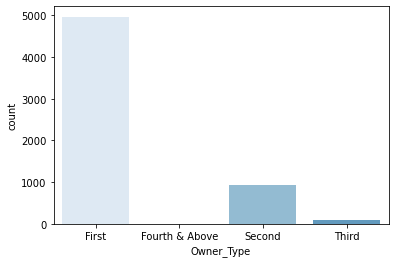

In [57]:
df['Owner_Type'] = df['Owner_Type'].astype('category')
sns.countplot("Owner_Type", data=df)

In [58]:
model = ols('Price ~ Owner_Type', data=df).fit()
anova_table = sm.stats.anova_lm(model)
anova_table

,df,sum_sq,mean_sq,F,PR(>F)
Owner_Type,3.0,1.643021e+10,5.476737e+09,17.647989,2.107917e-11
Residual,5989.0,1.858579e+12,3.103321e+08,NaN,NaN


- F-통계량 : 17.647989
- p-value : 2.107917e-11


- 95% 신뢰구간에서 p-value가 0.05 미만으로, 귀무가설을 기각한다. 따라서 소유주 변경횟수별 가격 평균에는 차이가 있다.

##### 중고차 가격과 브랜드에 대한 가설검정: AVONA

* H0 = 브랜드별 가격 평균의 차이가 없다.
* H1 = 브랜드별 가격 평균의 차이가 있다.

In [59]:
df['Name'].value_counts()

Maruti           1218
Hyundai          1069
Honda             612
Toyota            394
Volkswagen        318
Mercedes-Benz     310
Ford              296
Mahindra          276
BMW               267
Audi              238
Tata              189
Skoda             177
Renault           151
Chevrolet         119
Nissan             93
Land               51
Jaguar             43
Mitsubishi         34
Mini               29
Fiat               26
Volvo              21
Jeep               19
Datsun             17
Porsche            16
ISUZU               3
Force               3
Bentley             2
Ambassador          1
Lamborghini         1
Name: Name, dtype: int64

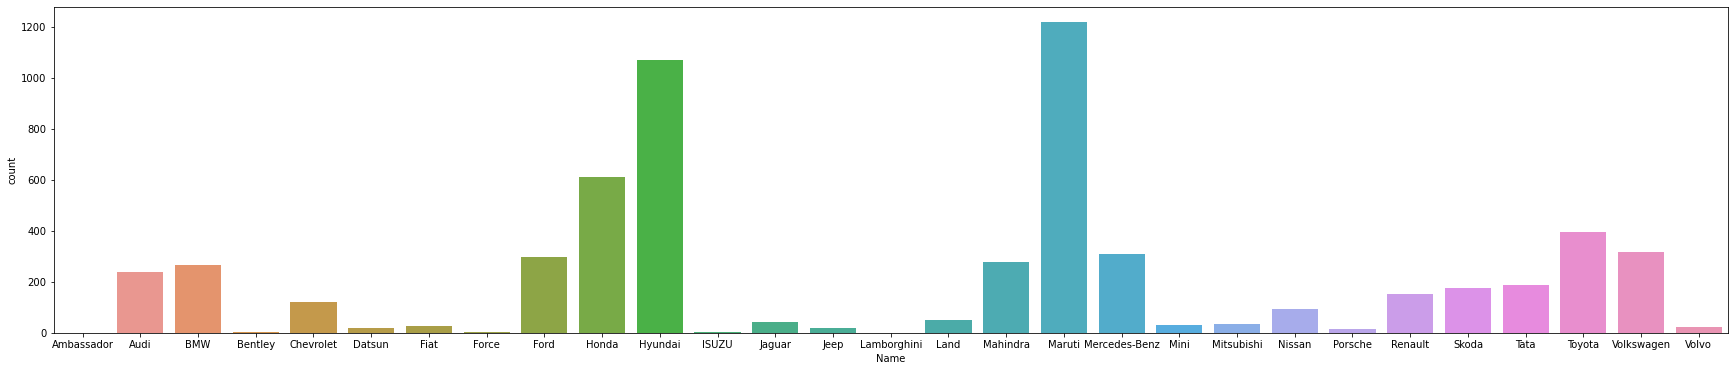

In [60]:
df['Name'] = df['Name'].astype('category')

plt.figure(figsize=(30, 6))
sns.countplot(x="Name", data=df)
plt.show()

In [61]:
model = ols('Price ~ Name', data=df).fit()
anova_table = sm.stats.anova_lm(model)
anova_table

,df,sum_sq,mean_sq,F,PR(>F)
Name,28.0,1.088828e+12,3.888671e+10,294.995996,0.0
Residual,5964.0,7.861813e+11,1.318211e+08,NaN,NaN


- F-통계량 : 294.995996
- p-value : 0


- 95% 신뢰구간에서 p-value가 0.05 미만으로, 귀무가설을 기각한다. 따라서 브랜드별 가격 평균에는 차이가 있다.

In [62]:
df.dtypes

Name                 category
Location             category
Price                 float64
Year                    int64
Kilometers_Driven       int64
Fuel_Type            category
Transmission         category
Owner_Type           category
Mileage               float64
Engine                float64
Power                 float64
Seats                 float64
Year_start              int64
dtype: object

In [63]:
#설명변수 간 다중공선성 확인
df_ = df[df.describe().columns]
df_const = add_constant(df_)
df_vif = pd.DataFrame()
df_vif["variable"]= df_const.columns
df_vif["VIF"]=[variance_inflation_factor(df_const.values, i)\
              for i in range(df_const.shape[1])]
df_vif.sort_values("VIF", ascending=True).round(2)

,variable,VIF
0,const,0.00
3,Kilometers_Driven,1.57
7,Seats,1.84
4,Mileage,2.07
1,Price,2.94
6,Power,7.57
5,Engine,7.76
2,Year,inf
8,Year_start,inf


- 연식과 생산년도의 VIF가 inf로 다중공선성 문제를 해결하기 위해선 Year와 Year_start 변수를 삭제

### 더미화(One-Hot Encoding)

In [64]:
df_dummy = pd.get_dummies(df)
df_dummy.head()

,Price,Year,Kilometers_Driven,Mileage,Engine,Power,Seats,Year_start,Name_Ambassador,Name_Audi,...,Fuel_Type_CNG,Fuel_Type_Diesel,Fuel_Type_LPG,Fuel_Type_Petrol,Transmission_Automatic,Transmission_Manual,Owner_Type_First,Owner_Type_Fourth & Above,Owner_Type_Second,Owner_Type_Third
0,2682.68,2010,72000,26.60,998.0,58.16,5.0,13,0,0,...,1,0,0,0,0,1,1,0,0,0
1,19162.00,2015,41000,19.67,1582.0,126.20,5.0,8,0,0,...,0,1,0,0,0,1,1,0,0,0
2,6898.32,2011,46000,18.20,1199.0,88.70,5.0,12,0,0,...,0,0,0,1,0,1,1,0,0,0
3,9197.76,2012,87000,20.77,1248.0,88.76,7.0,11,0,0,...,0,1,0,0,0,1,1,0,0,0
4,27194.71,2013,40670,15.20,1968.0,140.80,5.0,10,0,1,...,0,1,0,0,1,0,0,0,1,0


### 데이터 분리

In [65]:
df_train, df_test = train_test_split(df_dummy, test_size=0.3)

print("train data size: {}".format(df_train.shape))
print("test_X data size: {}".format(df_test.shape))

train data size: (4195, 58)
test_X data size: (1798, 58)


In [66]:
#데이터 split
df_train_x, df_test_x = train_test_split(df_dummy, test_size=0.3)
df_train_y = df_train_x['Price']
df_test_y = df_test_x['Price']
df_train_x = df_train_x.drop('Price', axis = 1)
df_test_x = df_test_x.drop('Price', axis = 1)
print("train_X data size: {}".format(df_train_x.shape))
print("train_Y data size: {}".format(df_train_y.shape))
print("test_X data size: {}".format(df_test_x.shape))
print("test_Y data size: {}".format(df_test_y.shape))

train_X data size: (4195, 57)
train_Y data size: (4195,)
test_X data size: (1798, 57)
test_Y data size: (1798,)


In [67]:
df_train.columns = ['Price', 'Year', 'Kilometers_Driven', 'Mileage', 'Engine', 'Power',
       'Seats', 'Year_start', 'Name_Ambassador', 'Name_Audi', 'Name_BMW',
       'Name_Bentley', 'Name_Chevrolet', 'Name_Datsun', 'Name_Fiat',
       'Name_Force', 'Name_Ford', 'Name_Honda', 'Name_Hyundai', 'Name_ISUZU',
       'Name_Jaguar', 'Name_Jeep', 'Name_Lamborghini', 'Name_Land',
       'Name_Mahindra', 'Name_Maruti', 'Name_Mercedes_Benz', 'Name_Mini',
       'Name_Mitsubishi', 'Name_Nissan', 'Name_Porsche', 'Name_Renault',
       'Name_Skoda', 'Name_Tata', 'Name_Toyota', 'Name_Volkswagen',
       'Name_Volvo', 'Location_Ahmedabad', 'Location_Bangalore',
       'Location_Chennai', 'Location_Coimbatore', 'Location_Delhi',
       'Location_Hyderabad', 'Location_Jaipur', 'Location_Kochi',
       'Location_Kolkata', 'Location_Mumbai', 'Location_Pune', 'Fuel_Type_CNG',
       'Fuel_Type_Diesel', 'Fuel_Type_LPG', 'Fuel_Type_Petrol',
       'Transmission_Auto_matic', 'Transmission_Manual', 'Owner_Type_First',
       'Owner_Type_Fourth_Above', 'Owner_Type_Second', 'Owner_Type_Third']

df_test.columns = ['Price', 'Year', 'Kilometers_Driven', 'Mileage', 'Engine', 'Power',
       'Seats', 'Year_start', 'Name_Ambassador', 'Name_Audi', 'Name_BMW',
       'Name_Bentley', 'Name_Chevrolet', 'Name_Datsun', 'Name_Fiat',
       'Name_Force', 'Name_Ford', 'Name_Honda', 'Name_Hyundai', 'Name_ISUZU',
       'Name_Jaguar', 'Name_Jeep', 'Name_Lamborghini', 'Name_Land',
       'Name_Mahindra', 'Name_Maruti', 'Name_Mercedes_Benz', 'Name_Mini',
       'Name_Mitsubishi', 'Name_Nissan', 'Name_Porsche', 'Name_Renault',
       'Name_Skoda', 'Name_Tata', 'Name_Toyota', 'Name_Volkswagen',
       'Name_Volvo', 'Location_Ahmedabad', 'Location_Bangalore',
       'Location_Chennai', 'Location_Coimbatore', 'Location_Delhi',
       'Location_Hyderabad', 'Location_Jaipur', 'Location_Kochi',
       'Location_Kolkata', 'Location_Mumbai', 'Location_Pune', 'Fuel_Type_CNG',
       'Fuel_Type_Diesel', 'Fuel_Type_LPG', 'Fuel_Type_Petrol',
       'Transmission_Auto_matic', 'Transmission_Manual', 'Owner_Type_First',
       'Owner_Type_Fourth_Above', 'Owner_Type_Second', 'Owner_Type_Third']

# 모델링

###  Linear Regression

In [68]:
# 다중회귀

formula = df_train.columns
l = [formula[i+1]+'+' for i in range(len(formula)-1)]
l.append('Owner_Type_Third')
reg_model = smf.ols(formula = 'Price~'+''.join(l), data=df_train)
result = reg_model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.766
Model:                            OLS   Adj. R-squared:                  0.763
Method:                 Least Squares   F-statistic:                     265.8
Date:                Mon, 06 Mar 2023   Prob (F-statistic):               0.00
Time:                        03:01:36   Log-Likelihood:                -43974.
No. Observations:                4195   AIC:                         8.805e+04
Df Residuals:                    4143   BIC:                         8.838e+04
Df Model:                          51                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -0.6402      0.030    -21.437      0.000      -0.699      -0.582
Year                        8.6275      1.469      5.873      0.000       5.747      11.508
Kilometers_Driven          -0.0518      0.006     -8.919      0.000      -0.063      -0.040
Mileage                  -192.8331     65.572     -2.941      0.003    -321.390     -64.276
Engine                      2.3347      0.796      2.934      0.003       0.775       3.895
Power                     137.3994      8.092     16.981      0.000     121.536     153.263
Seats                     483.8800    268.877      1.800      0.072     -43.264    1011.024
Year_start              -1303.6829     60.981    -21.378      0.000   -1423.239   -1184.127
Name_Ambassador          4420.2636   8504.931      0.520      0.603   -1.23e+04    2.11e+04
Name_Audi                6713.5700    918.995      7.305      0.000    4911.847    8515.293
Name_BMW                 3134.7783    934.643      3.354      0.001    1302.376    4967.181
Name_Bentley            -4.112e+04   6390.528     -6.435      0.000   -5.37e+04   -2.86e+04
Name_Chevrolet          -8942.8778   1185.220     -7.545      0.000   -1.13e+04   -6619.211
Name_Datsun                 -1e+04   2257.952     -4.430      0.000   -1.44e+04   -5576.137
Name_Fiat               -8279.9857   2219.851     -3.730      0.000   -1.26e+04   -3927.885
Name_Force              -1.342e+04   4909.975     -2.733      0.006    -2.3e+04   -3792.946
Name_Ford               -7103.0244    882.203     -8.051      0.000   -8832.615   -5373.434
Name_Honda              -9256.5421    785.710    -11.781      0.000   -1.08e+04   -7716.129
Name_Hyundai            -8380.0612    751.769    -11.147      0.000   -9853.932   -6906.191
Name_ISUZU              -1.532e+04   4921.692     -3.113      0.002    -2.5e+04   -5670.195
Name_Jaguar               1.76e+04   1732.140     10.163      0.000    1.42e+04     2.1e+04
Name_Jeep               -6771.3775   2212.192     -3.061      0.002   -1.11e+04   -2434.293
Name_Lamborghini         9.671e+04   8744.276     11.059      0.000    7.96e+04    1.14e+05
Name_Land                3.092e+04   1524.789     20.276      0.000    2.79e+04    3.39e+04
Name_Mahindra            -1.21e+04    982.815    -12.307      0.000    -1.4e+04   -1.02e+04
Name_Maruti             -6265.7514    797.908     -7.853      0.000   -7830.079   -4701.424
Name_Mercedes_Benz       6591.8589    863.569      7.633      0.000    4898.800    8284.917
Name_Mini                1.622e+04   1872.094      8.664      0.000    1.25e+04    1.99e+04
Name_Mitsubishi         -2268.2785   1737.212     -1.306      0.192   -5674.147    1137.590
Name_Nissan             -7710.0709   1252.047     -6.158      0.000   -1.02e+04   -5255.386
Name_Porsche             2.012e+04   2635.546  

- 수정결정계수에 따르면 모델의 설명력은 75.4%



- 회귀식 잔차의 독립성을 검증하는 더빈왓슨계수는 1.938으로, 2에 가까울수록 자기상관성이 없다. 따라서 잔차는 독립성을 만족한다.

- Mileage, Seats, transmission, Owner_Type은 유의수준 0.05 하에 P-value가 0.05보다 크므로 유의하지 않다.


- Location, Name 변수는 한 개라도 유의한 변수가 존재하므로 전체 변수를 유의하다고 판단하였음

In [69]:
# 평가용 데이터에 대한 성능 확인

train_pred = result.predict(df_train)
test_pred = result.predict(df_test)
print('train data의 결정계수: ', r2_score(df_train['Price'], train_pred))
print('test data의 결정계수: ', r2_score(df_test['Price'], test_pred))

train data의 결정계수:  0.7658915356678946
test data의 결정계수:  0.7347008544863354


- 훈련 세트에 대한 결정계수 약 75.7%로 나타남
- 테스트 세트에 대한 결정계수는 약 75.88%로 나타남

### Decision Tree

In [75]:
# Decision Tree 

dt_model = DecisionTreeRegressor()
dt_model.fit(df_train_x, df_train_y)

DecisionTreeRegressor()

In [80]:
# train data score 확인
train_pred = dt_model.predict(df_train_x)
test_pred = dt_model.predict(df_test_x)

print('train data의 결정계수: ',dt_model.score(df_train_x, df_train_y).round(4))
print('test data의 결정계수: ',dt_model.score(df_test_x, df_test_y).round(4))

train data의 결정계수:  1.0
test data의 결정계수:  0.7085


In [86]:
# GridSearch

param_grid = {'max_depth': range(2, 10),
              'min_samples_split': range(2,40,2),
              'min_samples_leaf': range(2,20,2)}

grid_dt = GridSearchCV(dt_model, param_grid, cv = 3, n_jobs = -1)
grid_dt.fit(df_train_x, df_train_y)

print('best model: \n{}'.format(grid_dt.best_estimator_))
print('\nbest parameter: \n{}'.format(grid_dt.best_params_))
print('\nbest score: \n{}'.format(grid_dt.best_score_.round(3)))
print('\nbest set score: \n{}'.format(grid_dt.score(df_test_x, df_test_y).round(3)))

best model: 
DecisionTreeRegressor(max_depth=9, min_samples_leaf=2, min_samples_split=14)

best parameter: 
{'max_depth': 9, 'min_samples_leaf': 2, 'min_samples_split': 14}

best score: 
0.79

best set score: 
0.834


In [87]:
# 최종 Decision Tree

tree_final = DecisionTreeRegressor(min_samples_leaf = 2, min_samples_split = 14, max_depth = 9, random_state = 1234)
tree_final.fit(df_train_x, df_train_y)

DecisionTreeRegressor(max_depth=9, min_samples_leaf=2, min_samples_split=14,
                      random_state=1234)

In [88]:
# Train 데이터 설명력
print("Train data의 결정계수: {:.3f}".format(tree_final.score(df_train_x, df_train_y).round(3)))
print("Test data의 결정계수: {:.3f}".format(tree_final.score(df_test_x, df_test_y).round(3)))

Train data의 결정계수: 0.905
Test data의 결정계수: 0.833


In [90]:
# tree feature_importance로 설명변수 중요도 확인 및 데이터 테이블로 저장
df_importance = pd.DataFrame()
df_importance['Feature'] = df_train_x.columns
df_importance['Importance'] = tree_final.feature_importances_

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


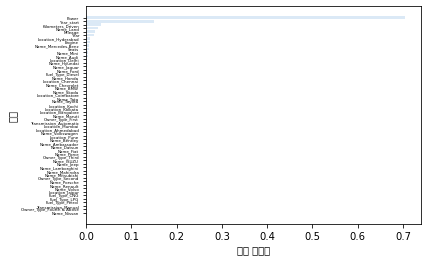

In [91]:
# 설명변수 중요도 그래프

df_importance.sort_values("Importance", ascending = True, inplace = True)
coordinates = range(len(df_importance))
plt.barh( y = coordinates, width = df_importance["Importance"])
plt.yticks(coordinates, df_importance['Feature'], size = 4)
plt.xlabel("변수 중요도")
plt.ylabel("변수")
plt.show()

In [92]:
# 중요도별로 정렬
df_importance.sort_values("Importance", ascending = False, inplace = True)
df_importance

,Feature,Importance
4,Power,0.704234
6,Year_start,0.150384
1,Kilometers_Driven,0.033158
22,Name_Land,0.026732
2,Mileage,0.019006
0,Year,0.016475
41,Location_Hyderabad,0.009066
3,Engine,0.007738
25,Name_Mercedes-Benz,0.006567
5,Seats,0.005547


- 변수는 Power > Year_start > Year > Kilometers_Driven > Seats > Mileage > Engine > ... 순으로 중요함

### Random Forest

In [93]:
# Random Forest 모델 생성 및 학습
rf_model = RandomForestRegressor()
rf_model.fit(df_train_x, df_train_y)

RandomForestRegressor()

In [94]:
# train data score 확인
train_pred = rf_model.predict(df_train_x)
rf_model.score(df_train_x, df_train_y)

0.9778965362113579

In [95]:
# test data score 확인
test_pred = rf_model.predict(df_test_x)
rf_model.score(df_test_x, df_test_y)

0.8884685611363098

In [96]:
# GridSearchCV

param_grid = {'max_depth': range(2, 10),
              'min_samples_split': range(2,40,2),
              'min_samples_leaf': range(2,20,2)}
grid_rf = GridSearchCV(dt_model, param_grid, cv = 3, n_jobs = -1)
grid_rf.fit(df_train_x, df_train_y)

print('best model: \n{}'.format(grid_rf.best_estimator_))
print('\nbest parameter: \n{}'.format(grid_rf.best_params_))
print('\nbest score: \n{}'.format(grid_rf.best_score_.round(3)))
print('\nbest set score: \n{}'.format(grid_rf.score(df_test_x, df_test_y).round(3)))

best model: 
DecisionTreeRegressor(max_depth=9, min_samples_leaf=2, min_samples_split=14)

best parameter: 
{'max_depth': 9, 'min_samples_leaf': 2, 'min_samples_split': 14}

best score: 
0.79

best set score: 
0.833


In [97]:
rf_final = RandomForestRegressor(min_samples_leaf = 6, min_samples_split = 8, max_depth = 9, random_state = 1234)
rf_final.fit(df_train_x, df_train_y)

RandomForestRegressor(max_depth=9, min_samples_leaf=6, min_samples_split=8,
                      random_state=1234)

In [98]:
# Train 데이터 설명력
print("Train data의 결정계수: {:.3f}".format(rf_final.score(df_train_x, df_train_y).round(3)))
print("Test data의 결정계수: {:.3f}".format(rf_final.score(df_test_x, df_test_y).round(3)))

Train data의 결정계수: 0.892
Test data의 결정계수: 0.881


In [99]:
# tree feature_importance로 설명변수 중요도 확인 및 데이터 테이블로 저장
rf_importance = pd.DataFrame()
rf_importance['Feature'] = df_train_x.columns
rf_importance['Importance'] = rf_final.feature_importances_

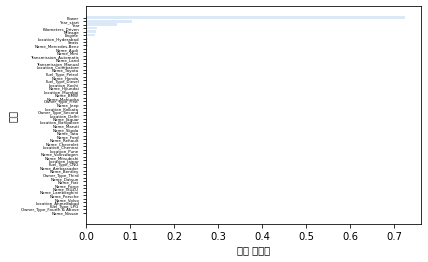

In [100]:
# 설명변수 중요도 그래프

rf_importance.sort_values("Importance", ascending = True, inplace = True)
coordinates = range(len(rf_importance))
plt.barh( y = coordinates, width = rf_importance["Importance"])
plt.yticks(coordinates, rf_importance['Feature'], size = 4)
plt.xlabel("변수 중요도")
plt.ylabel("변수")
plt.show()

In [101]:
# 중요도별로 정렬
rf_importance.sort_values("Importance", ascending = False, inplace = True)
rf_importance

,Feature,Importance
4,Power,7.249666e-01
6,Year_start,1.043780e-01
0,Year,6.960929e-02
1,Kilometers_Driven,2.416014e-02
2,Mileage,2.148310e-02
3,Engine,2.093552e-02
41,Location_Hyderabad,4.268584e-03
5,Seats,3.670355e-03
25,Name_Mercedes-Benz,3.455223e-03
8,Name_Audi,2.968154e-03


- 변수는 Power > Year_start > Year > Kilometers_Driven > Mileage > Engine > ... 순으로 중요함

### XGBOOST

In [70]:
# XGBOOST

estimator = XGBRegressor()
param_grid = {'n_estimators': [i*10 for i in range(1,16)], 'max_depth' : [i for i in range(1, 10)],
              'gamma' : [i for i in range(1,6)], 'learning_rate' : [i*0.1 for i in range(1,20)]}
xgb_model = RandomizedSearchCV(estimator, param_grid, n_jobs = -1)
xgb_model.fit(df_train_x, df_train_y)

print('Best parameters: ', xgb_model.best_params_)
print('Best score: ', xgb_model.best_score_)

Best parameters:  {'n_estimators': 80, 'max_depth': 6, 'learning_rate': 0.30000000000000004, 'gamma': 1}
Best score:  0.8377589066701614


In [71]:
best_model = xgb_model.best_estimator_

print('Score on training set: {:.3f}'.format(xgb_model.score(df_train_x, df_train_y)))
print('Score on test set: {:.3f}'.format(xgb_model.score(df_test_x, df_test_y)))

Score on training set: 0.991
Score on test set: 0.866


In [103]:
xgb_final = XGBRegressor(n_estimators = 80, learning_rate = 0.3, gamma = 1, max_depth = 6, random_state = 1234)
xgb_final.fit(df_train_x, df_train_y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=1, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.3, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=80, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=1234, ...)

In [104]:
# 데이터 설명력
print("Train data의 결정계수: {:.3f}".format(xgb_final.score(df_train_x, df_train_y).round(3)))
print("Test data의 결정계수: {:.3f}".format(xgb_final.score(df_test_x, df_test_y).round(3)))

Train data의 결정계수: 0.991
Test data의 결정계수: 0.866


In [108]:
xgb_importance = pd.DataFrame()
xgb_importance['Feature'] = df_train_x.columns
xgb_importance['Importance'] = xgb_final.feature_importances_

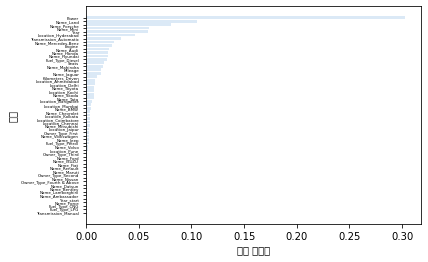

In [109]:
# 설명변수 중요도 그래프

xgb_importance.sort_values("Importance", ascending = True, inplace = True)
coordinates = range(len(xgb_importance))
plt.barh( y = coordinates, width = xgb_importance["Importance"])
plt.yticks(coordinates, xgb_importance['Feature'], size = 4)
plt.xlabel("변수 중요도")
plt.ylabel("변수")
plt.show()

In [110]:
# 중요도별로 정렬
xgb_importance.sort_values("Importance", ascending = False, inplace = True)
xgb_importance

,Feature,Importance
4,Power,0.302627
22,Name_Land,0.105589
29,Name_Porsche,0.080973
26,Name_Mini,0.060041
0,Year,0.059029
41,Location_Hyderabad,0.046860
51,Transmission_Automatic,0.033192
25,Name_Mercedes-Benz,0.026687
3,Engine,0.024949
8,Name_Audi,0.021714


- 변수 중요도는 Powe -> Name_Land -> Name_Porche -> Name_Mini ... 순으로 중요함

#### 결정계수가 89.1%로 가장 높은 RandomForest 모델을 최종 모델로 선정


#### 변수 중요도를 통해 Power, Year, Year_start, Name_Land, Kilometers_Driven을 VF로 선정


#### 단, 계산된 변수 중요도 값이 낮거나 0이더라도 선택되는 데이터에 따라 중요도가 변경될 수 있음

# 모델 개선안

#### 중고차 가격 예측 모델은 Random Forest 모델로 선정
  - Modeling 후 평가지표(r2)로, 평가결과는 Random Forest이 가장 크게 나타남
  - Random Forest > XGBoost > Decision Tree > Linear Regression


#### Modeling 후 성능도 Random Forest 모델이 가장 높게 나타남
  - 순서는 RandomForest(training set: 0.892, test set : 0.881), XGBoost(training set : 0.991, test set : 0.866), Decision Tree(training set: 0.905, test set: 0.833), Linear Regression(training set: 0.765, test set: 0.734)이다.

1. 목표변수('Price') 결측치에 대해 제거를 하였으나, 대체 방법 추가 검토
2. 설명변수 분포의 변환 검토
  - Engine, Power 분포: 좌측으로 기울어짐
3. 데이터 추가 또는 파생변수의 생성 검토